In [1]:
# Change directory
import os
os.chdir("..")

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from raw_slope_functions import calculate_slopes_se, run_ttest

In [3]:
# import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv")

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

In [7]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit, cal_window_size, sampleDelimit, sample_window_size):
    cal_window_start = bubble_start - calDelimit
    cal_window_end = cal_window_start + cal_window_size
    sample_window_start = sample_start + sampleDelimit
    sample_window_end = sample_window_start + sample_window_size
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# For sensor A in system 1
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start = A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start = A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size
                                                                                                   )
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# For sensor A in system 2
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end

In [8]:
# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

# For sensor B in system 1, blood and aqueous
B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

In [9]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# extract window data for sensor A in system 1
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)
A1_cal_window.dropna(inplace=True)
A1_sample_window.dropna(inplace=True)

# extract window data for sensor A in system 2
A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)
A2_cal_window.dropna(inplace=True)
A2_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 1
B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID']
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)
B1_cal_window.dropna(inplace=True)
B1_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 2
B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID']
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)
B2_cal_window.dropna(inplace=True)
B2_sample_window.dropna(inplace=True)


In [10]:
# Merge attributes with extracted cal and sample window

# Sensor A
A1_attributes = A1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A1_cal_window = A1_cal_window.reset_index()
A1_cal_window_binned = A1_attributes.merge(A1_cal_window, how = "inner", on = "TestID")
A1_sample_window = A1_sample_window.reset_index()
A1_sample_window_binned = A1_attributes.merge(A1_sample_window, how = "inner", on = "TestID")

A2_attributes = A2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
A2_cal_window = A2_cal_window.reset_index()
A2_cal_window_binned = A2_attributes.merge(A2_cal_window, how = "inner", on = "TestID")
A2_sample_window = A2_sample_window.reset_index()
A2_sample_window_binned = A2_attributes.merge(A2_sample_window, how = "inner", on = "TestID")

# Sensor B
B1_attributes = B1_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B1_cal_window = B1_cal_window.reset_index()
B1_cal_window_binned = B1_attributes.merge(B1_cal_window, how = "inner", on = "TestID")
B1_sample_window = B1_sample_window.reset_index()
B1_sample_window_binned = B1_attributes.merge(B1_sample_window, how = "inner", on = "TestID")

B2_attributes = B2_Merged[["TestID", "AmbientTemperature", "Fluid Temperature", "FluidType", "AgeOfCardInDaysAtTimeOfTest"]]
B2_cal_window = B2_cal_window.reset_index()
B2_cal_window_binned = B2_attributes.merge(B2_cal_window, how = "inner", on = "TestID")
B2_sample_window = B2_sample_window.reset_index()
B2_sample_window_binned = B2_attributes.merge(B2_sample_window, how = "inner", on = "TestID")

In [11]:
# Calculate sample size for each system and sensors calibration and sample window
N_A1_cal = A1_cal_window.shape[1]
N_A2_cal = A2_cal_window.shape[1]
N_A1_sample = A1_sample_window.shape[1]
N_A2_sample = A2_sample_window.shape[1]

N_B1_cal = B1_cal_window.shape[1]
N_B2_cal = B2_cal_window.shape[1]
N_B1_sample = B1_sample_window.shape[1]
N_B2_sample = B2_sample_window.shape[1]

# **Fluid Type**

## **Sensor A**

In [12]:
# Slopes
labels = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5', 'AB', 'HNB', 'NB', 'SB-3', 'DB', 'TB11', 'SB']
A1_cal = calculate_slopes_se(A1_cal_window_binned, "FluidType", labels)
A1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

A1_sample = calculate_slopes_se(A1_sample_window_binned, "FluidType", labels)
A1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

A2_cal = calculate_slopes_se(A2_cal_window_binned, "FluidType", labels)
A2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

A2_sample = calculate_slopes_se(A2_sample_window_binned, "FluidType", labels)
A2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_A_slopes = pd.concat([A1_cal, A2_cal, A1_sample, A2_sample],axis = 1)
Sensor_A_slopes.index = labels
Sensor_A_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Eurotrol L1,0.010366,0.000017,0.007642,0.000015,-0.000630,0.000138,0.006423,0.000123
Eurotrol L3,0.010634,0.000021,0.008187,0.000014,-0.000628,0.000166,0.005526,0.000099
Eurotrol L4,0.021483,0.000037,0.022422,0.000004,0.004963,0.000167,0.017728,0.000114
Eurotrol L5,0.012007,0.000026,0.005445,0.000017,-0.001689,0.000191,0.002824,0.000065
AB,-0.006141,0.000017,-0.007926,0.000043,-0.010200,0.000083,-0.006884,0.000066
HNB,0.017347,0.000035,0.014883,0.000018,0.006471,0.000159,0.013761,0.000116
NB,0.020807,0.000038,0.022699,0.000009,0.008606,0.000165,0.019267,0.000114
SB-3,0.015295,0.000030,0.018705,0.000024,0.000434,0.000100,0.006921,0.000153
DB,0.022293,0.000040,0.022582,0.000007,0.015647,0.000288,0.032312,0.000101
TB11,0.021898,0.000046,0.024530,0.000018,0.011716,0.000106,0.022371,0.000115


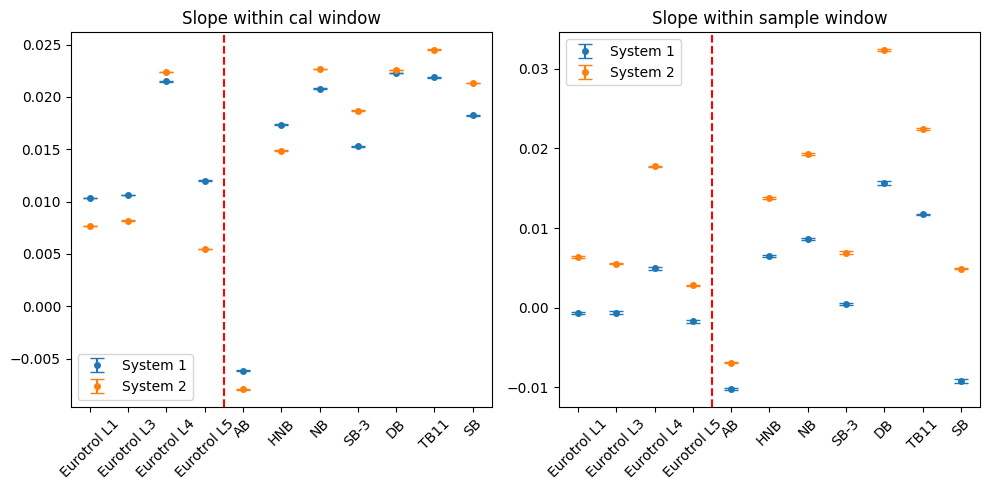

In [13]:
# Plot of slopes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-1-cal-slope"], yerr=Sensor_A_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_A_slopes["System-2-cal-slope"], yerr=Sensor_A_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-1-sample-slope"], yerr=Sensor_A_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_A_slopes["System-2-sample-slope"], yerr=Sensor_A_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

for ax in axes:
    ax.axvline(x=3.5, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [14]:
# T-tests to compare slopes in each bin
ttest_A = run_ttest(Sensor_A_slopes, N_A1_cal, N_A2_cal, N_A1_sample, N_A2_sample, labels)
ttest_A

,t-statistic-cal,p-value-cal,t-statistic-sample,p-value-sample
Eurotrol L1,120.648803,0.000000e+00,-38.175330,0.0
Eurotrol L3,99.080785,0.000000e+00,-31.865951,0.0
Eurotrol L4,-25.201529,0.000000e+00,-63.163997,0.0
Eurotrol L5,210.711821,0.000000e+00,-22.393849,0.0
AB,38.737782,0.000000e+00,-31.428874,0.0
HNB,63.064327,0.000000e+00,-37.120288,0.0
NB,-48.206279,0.000000e+00,-53.138222,0.0
SB-3,-89.805244,0.000000e+00,-35.442008,0.0
DB,-7.151951,3.249729e-10,-54.585209,0.0
TB11,-53.365664,0.000000e+00,-68.303467,0.0


## **Sensor B**

In [15]:
# Slopes
labels = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5', 'AB', 'HNB', 'NB', 'SB-3', 'DB', 'TB11', 'SB']
B1_cal = calculate_slopes_se(B1_cal_window_binned, "FluidType", labels)
B1_cal.columns = ['System-1-cal-slope', 'System-1-cal-se']

B1_sample = calculate_slopes_se(B1_sample_window_binned, "FluidType", labels)
B1_sample.columns = ['System-1-sample-slope', 'System-1-sample-se']

B2_cal = calculate_slopes_se(B2_cal_window_binned, "FluidType", labels)
B2_cal.columns = ['System-2-cal-slope', 'System-2-cal-se']

B2_sample = calculate_slopes_se(B2_sample_window_binned, "FluidType", labels)
B2_sample.columns = ['System-2-sample-slope', 'System-2-sample-se']

Sensor_B_slopes = pd.concat([B1_cal, B2_cal, B1_sample, B2_sample],axis = 1)
Sensor_B_slopes.index = labels
Sensor_B_slopes

,System-1-cal-slope,System-1-cal-se,System-2-cal-slope,System-2-cal-se,System-1-sample-slope,System-1-sample-se,System-2-sample-slope,System-2-sample-se
Eurotrol L1,0.036585,0.000035,0.044392,0.000044,0.050204,0.000292,0.058247,0.000281
Eurotrol L3,0.036775,0.000036,0.045007,0.000045,0.035858,0.000141,0.045654,0.000140
Eurotrol L4,0.037097,0.000048,0.042764,0.000054,0.049011,0.000297,0.055426,0.000304
Eurotrol L5,0.038749,0.000044,0.046179,0.000044,-0.008749,0.000366,0.019134,0.000300
AB,0.043204,0.000020,0.047938,0.000035,0.051884,0.000192,0.056812,0.000209
HNB,0.038287,0.000045,0.045391,0.000048,0.042657,0.000200,0.048749,0.000204
NB,0.036863,0.000050,0.043577,0.000052,0.041600,0.000195,0.049182,0.000214
SB-3,0.027915,0.000024,0.036499,0.000048,0.025839,0.000247,0.033135,0.000228
DB,0.036800,0.000049,0.043594,0.000056,0.034987,0.000029,0.049002,0.000077
TB11,0.037012,0.000055,0.043441,0.000055,0.045322,0.000161,0.056744,0.000214


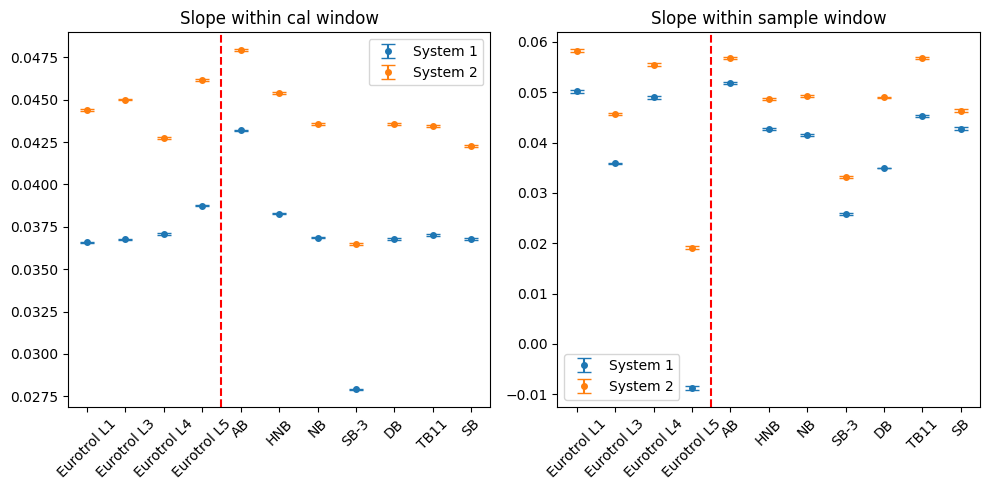

In [16]:
# Plot of slopes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-1-cal-slope"], yerr=Sensor_B_slopes["System-1-cal-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[0].errorbar(range(len(labels)), Sensor_B_slopes["System-2-cal-slope"], yerr=Sensor_B_slopes["System-2-cal-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[0].set_xticks(range(len(labels)))  
axes[0].set_xticklabels(labels=labels, rotation=45)
axes[0].legend(["System 1", "System 2"])
axes[0].set_title("Slope within cal window")

axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-1-sample-slope"], yerr=Sensor_B_slopes["System-1-sample-se"], label="System 1", fmt='o', markersize=4, capsize=5)
axes[1].errorbar(range(len(labels)), Sensor_B_slopes["System-2-sample-slope"], yerr=Sensor_B_slopes["System-2-sample-se"], label="System 2", fmt='o', markersize=4, capsize=5)
axes[1].set_xticks(range(len(labels)))  
axes[1].set_xticklabels(labels=labels, rotation=45)
axes[1].legend(["System 1", "System 2"])
axes[1].set_title("Slope within sample window")

for ax in axes:
    ax.axvline(x=3.5, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [17]:
# T-tests to compare slopes in each bin
ttest_B = run_ttest(Sensor_B_slopes, N_B1_cal, N_B2_cal, N_B1_sample, N_B2_sample, labels)
ttest_B

,t-statistic-cal,p-value-cal,t-statistic-sample,p-value-sample
Eurotrol L1,-139.256939,0.0,-19.874456,0.000000e+00
Eurotrol L3,-142.659890,0.0,-49.285859,0.000000e+00
Eurotrol L4,-78.515222,0.0,-15.089769,0.000000e+00
Eurotrol L5,-119.187257,0.0,-58.905381,0.000000e+00
AB,-117.943766,0.0,-17.336125,0.000000e+00
HNB,-107.139560,0.0,-21.331796,0.000000e+00
NB,-93.591519,0.0,-26.201890,0.000000e+00
SB-3,-160.000107,0.0,-21.706098,0.000000e+00
DB,-91.034062,0.0,-170.294684,0.000000e+00
TB11,-82.631120,0.0,-42.634646,0.000000e+00
